In [122]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_adata(adata_to_plot, cluster_key, plot_type="umap", keyword=None, save=None, Title = "UMAP or Spatial embedding — clusters"):
    """
    Plot AnnData embeddings (UMAP or spatial) with optional HTML export.

    Parameters:
    - adata_to_plot: AnnData object with .obsm and .obs fields.
    - cluster_key: key in adata.obs to color by.
    - plot_type: "umap" or "spatial".
    - keyword: if provided, highlight clusters containing this substring; others grouped as "Other".
    - save: if None, do not save; if str, full path/filename to save as HTML (no extension needed).
    """

    # Prepare DataFrame for plotting
    if plot_type == "spatial":
        coords = adata_to_plot.obsm['spatial'].copy()
        df = pd.DataFrame(coords, columns=['x', 'y'], index=adata_to_plot.obs_names)
    else:  # UMAP
        df = pd.DataFrame(
            adata_to_plot.obsm['X_umap'],
            columns=['UMAP1', 'UMAP2'],
            index=adata_to_plot.obs_names
        )

    # Original cluster labels as strings
    df[cluster_key] = adata_to_plot.obs[cluster_key].astype(str)

    # If a keyword is provided, label matching clusters, others as "Other"
    if keyword:
        df['plot_label'] = df[cluster_key].apply(lambda x: x if keyword in x else 'Other')
        color_key = 'plot_label'
        legend_title = f"Highlighted: {keyword}"
    else:
        color_key = cluster_key
        legend_title = cluster_key

    # Get a discrete color map
    tab20 = [mpl.colors.rgb2hex(c) for c in plt.get_cmap('tab20').colors]

    # Choose appropriate scatter fields
    if plot_type == "spatial":
        fig = px.scatter(
            df,
            x='x',
            y='y',
            color=color_key,
            title=Title,
            hover_name=df.index,
            width=1600,
            height=700
        )
        fig.update_traces(marker=dict(size=2, opacity=0.8))
        fig.update_yaxes(autorange='reversed')
    else:  # UMAP
        fig = px.scatter(
            df,
            x='UMAP1',
            y='UMAP2',
            color=color_key,
            title=Title,
            color_discrete_sequence=tab20,
            hover_name=df.index,
            width=1400,
            height=1200
        )
        fig.update_traces(marker=dict(size=3, opacity=0.8))

    # Adjust layout
    fig.update_layout(
        legend_title_text=legend_title,
        legend=dict(
            itemsizing='constant',
            traceorder='normal',
            bgcolor='rgba(255,255,255,0.5)',
            x=1.02,
            y=1
        ),
        margin=dict(l=20, r=200, t=50, b=20)
    )

    # Show plot
    fig.show()

    # Save if a path is given
    if isinstance(save, str):
        fig.write_html(f"{save}.html")

## Load the Adata

In [94]:
import spatialdata
import scanpy as sc


Tissue = "Region2"
#MajorType = "Mesenchymal_SubTypes"

#adata = sc.read_h5ad(f'/Volumes/ProstateCancerEvoMain/dbs/Ongoing/Collection/MajorAnnGroups/Results/{Tissue}/{Tissue}.{MajorType}.AnnDC.h5ad')
adata = sc.read_h5ad(f'/Volumes/ProstateCancerEvoMain/dbs/Ongoing/Collection/MajorAnnGroups/Results/{Tissue}/{Tissue}.AnnDc.All.h5ad')
adata

AnnData object with n_obs × n_vars = 266502 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'cell_type', 'leiden', 'major_cell_type_xenium_panel', 'assigned_celltype', 'MajorTypes'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial'

## Run FGSEA for the Groups

In [112]:
import scanpy as sc
import gseapy as gp

def go_fgsea(adata, ref, comp, cluster_key="leiden" , gene_set="GO_Biological_Process_2025", show_plot = False):
    Reference, Delta = adata[adata.obs[cluster_key] == ref], \
                       adata[adata.obs[cluster_key] == comp]
    
    adata_concat = sc.concat(
        [Reference, Delta],
        axis=0,
        join="inner",                # keep only shared variables
        label="subset",              # name of the new obs‐column
        keys=[ref, comp],
        merge="same"                 # assume var‐ and obsm‐entries are identical
    )

    if show_plot:
         sc.pl.umap(
         adata_concat,
         color="subset",
         palette=["red","blue"],
         size=20,
         title=f"UMAP Comparisons of {ref} as reference vs {comp} as comparison",
         alpha = 0.4)

    # 1) Run differential expression: PartialTumor vs TumorEnriched
    sc.tl.rank_genes_groups(
    adata_concat,
    groupby='subset',
    groups=[comp],
    reference=ref,
    method='t-test'          # or 't-test', 'logreg', etc.
    )

    # 2) Extract a pre-ranked list of genes (log₂-fold-changes)
    de_df = sc.get.rank_genes_groups_df(
    adata_concat,
    group=comp,
    key='rank_genes_groups'
    )
    rnk = de_df.set_index('names')['logfoldchanges']

    pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=gene_set,     # or path to your GMT file
    processes=4,
    permutation_num=10000,
    outdir=None)

    terms = pre_res.res2d.Term
    axs = pre_res.plot(terms=[terms[0], terms[1], terms[2]],
    #legend_kws={'loc': (1.2, 0)}, # set the legend loc
    show_ranking=True, # whether to show the second yaxis
    figsize=(6,12)
)

    return pre_res.res2d[pre_res.res2d["NOM p-val"] < 0.05]

## Return The p < 0.05 Dataframe

/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning:

invalid value encountered in log2

/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_33663/2788230209.py:43: DeprecationWarning:

processes is deprecated; use threads

2025-06-05 01:12:51,581 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2025-06-05 01:12:51,594 [WARNING] Duplicated values found in preranked stats: 0.76% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Allograft Rejection,-0.417499,-1.729848,0.0,0.039183,0.0319,30/95,11.25%,CCR5;CCL7;INHBA;IL2RA;CCR2;IL6;TLR3;CD3D;EGFR;...
1,prerank,Myc Targets V1,0.524975,1.7124,0.000236,0.043916,0.0447,38/76,25.17%,CCT7;VDAC1;SRSF2;TARDBP;MCM5;KPNA2;NOLC1;EIF4A...
6,prerank,Epithelial Mesenchymal Transition,-0.424437,-1.570485,0.005411,0.054557,0.1244,13/51,10.22%,WNT5A;MFAP5;INHBA;ITGB5;CXCL1;COL5A2;IL6;CDH2;...
4,prerank,KRAS Signaling Up,-0.413215,-1.585783,0.006037,0.072465,0.1106,24/59,19.07%,ETV5;HSD11B1;INHBA;TLR8;HDAC9;TSPAN7;CD37;TSPA...
5,prerank,Adipogenesis,0.50545,1.576251,0.006284,0.070469,0.2523,20/56,17.19%,BCL6;ME1;LPL;PTCD3;GBE1;PGM1;REEP6;ATL2;IMMT;S...
3,prerank,Fatty Acid Metabolism,0.555585,1.610938,0.006473,0.061351,0.1738,20/36,26.48%,ME1;CBR1;ALAD;SLC22A5;UGDH;CRYZ;REEP6;HADHB;PP...
2,prerank,Interferon Alpha Response,0.601141,1.624995,0.008553,0.077184,0.1479,10/25,9.70%,PNPT1;LPAR6;CSF1;IFI35;MOV10;HERC6;TAP1;IFIH1;...
7,prerank,mTORC1 Signaling,0.46333,1.5086,0.008581,0.119498,0.4572,29/75,23.54%,ME1;HSPA4;SLC9A3R1;SQSTM1;TOMM40;HSPA9;GBE1;PG...
13,prerank,Inflammatory Response,-0.342876,-1.38563,0.019066,0.150437,0.3881,23/84,16.07%,GCH1;RASGRP1;CXCR6;CCL7;INHBA;IL6;TLR3;CLEC5A;...
8,prerank,Oxidative Phosphorylation,0.511445,1.504377,0.020828,0.104325,0.4719,25/39,31.98%,VDAC1;MFN2;HADHA;LRPPRC;HSPA9;ATP5F1A;IMMT;ATP...


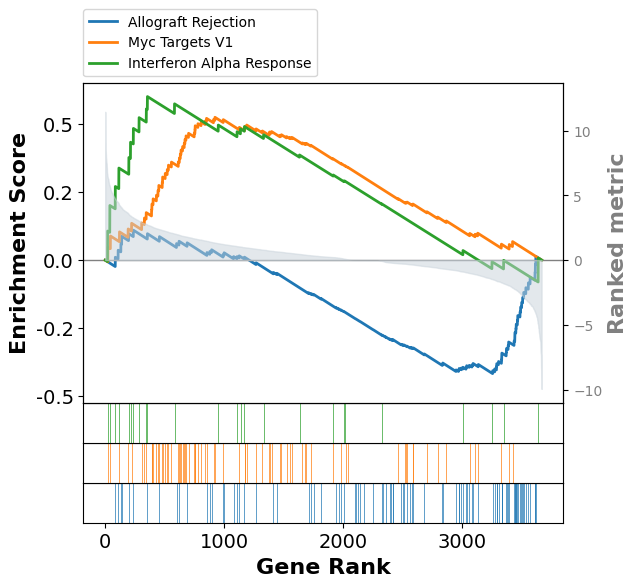

In [ ]:
pre_res = go_fgsea(adata, "5", "8", cluster_key="leiden" ,gene_set="MSigDB_Hallmark_2020" , show_plot=False)
pre_res.sort_values("NOM p-val").head(10)